In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

%matplotlib notebook
%matplotlib notebook

In [2]:

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [3]:
import glob 
def datasetImport(selectDatasets, dataset_name='ISONewEngland'):
    print('Dataset import has been started')

    all_files = glob.glob('./ISONewEngland/*.csv')
    # Initialize dataset list
    datasetList = []
    # Read all csv files and concat them
    for filename in all_files:
        if (filename.find("ISONE") != -1):
            for data in selectDatasets:
                if (filename.find(data) != -1):
                    df = pd.read_csv(filename,index_col=None, header=0)
                    datasetList.append(df)

    # Concat them all
    dataset = pd.concat(datasetList, axis=0, sort=False, ignore_index=True)
    dataset = dataset.iloc[:-24*60,:]
    return dataset


def dataCleaning(dataset, dataset_name='ISONewEngland'):
    print('Data cleaning function has been started')
    # Select X data
    X = dataset.iloc[:, :]
    if dataset_name.find('ONS') != -1:
        X = X.drop(['DEMAND'], axis=1)
    elif dataset_name.find('ISONewEngland') != -1:
        try:
            X = X.drop(['DEMAND','DA_DEMD','DA_LMP','DA_EC','DA_CC','DA_MLC','DATE','HOUR','RT_LMP','RT_EC','RT_CC','RT_MLC','SYSLoad','RegSP','RegCP'], axis=1)
        except KeyError:
            X = X.drop(['DEMAND','DA_DEMD','DA_LMP','DA_EC','DA_CC','DA_MLC','DATE','HOUR','RT_LMP','RT_EC','RT_CC','RT_MLC','SYSLoad'], axis=1)
        # Drop additional unused columns/features
        for columnNames in X.columns:
            if(columnNames.find("5min") != -1):
                X.drop([columnNames], axis=1, inplace=True)
    ## Pre-processing input data 
    # Verify zero values in dataset (X,y)
    print("Any null value in dataset?")
    print(dataset.isnull().any())
    print("How many are they?")
    print(dataset.isnull().sum())
    print("How many zero values?")
    print(dataset.eq(0).sum())
    print("How many zero values in y (DEMAND)?")
    print(dataset['DEMAND'].eq(0).sum())

    # Set y
    y = dataset['DEMAND'].astype(float)

    # Taking care of missing data
    print('Taking care of missing data')
    if (dataset['DEMAND'].eq(0).sum() > 0
        or dataset['DEMAND'].isnull().any()):    
        print(dataset[dataset['DEMAND'].isnull()])
        # Save the NaN indexes
        nanIndex = dataset[dataset['DEMAND'].isnull()].index.values
        # Replace zero values by NaN
        dataset['DEMAND'].replace(0, np.nan, inplace=True)
        #convert to float
        y = dataset['DEMAND'].astype(float)
        y = y.interpolate(method='linear', axis=0).ffill().bfill()
        print(y.iloc[nanIndex])


    return X, y


def featureEngineering(dataset, X, selectDatasets, weekday=False, holiday=False, holiday_bridge=False,  dataset_name='ONS'):
    print('Feature engineering has been started')
    # Decouple date and time from dataset
    # Then concat the decoupled date in different columns in X data


    print("Adding date components (year, month, day, holidays and weekdays) to input data")
    # Transform to date type
    X['DATE'] = pd.to_datetime(dataset.DATE)
    # X['DATE'] = pd.to_datetime(dataset.DATE, format="%d/%m/%Y %H:%M")

    date = X['DATE']
    Year = pd.DataFrame({'Year':date.dt.year})
    Month = pd.DataFrame({'Month':date.dt.month})
    Day = pd.DataFrame({'Day':date.dt.day})
    Hour = pd.DataFrame({'HOUR':date.dt.hour})

    if weekday:
        # Add weekday to X data
        Weekday = pd.DataFrame({'Weekday':date.dt.dayofweek})

    if holiday:
        # Add holidays to X data
        br_holidays = []
        for date2 in holidays.Brazil(years=list(map(int,selectDatasets))).items():
            br_holidays.append(str(date2[0]))

        # Set 1 or 0 for Holiday, when compared between date and br_holidays
        Holiday = pd.DataFrame({'Holiday':[1 if str(val).split()[0] in br_holidays else 0 for val in date]})

    
    # Concat all new features into X data
    try: 
        concatlist = [X,Year,Month,Day,Weekday,Hour,Holiday]
    except (AttributeError, ValueError, KeyError, UnboundLocalError) as e:
        concatlist = [X,Year,Month,Day,Hour]
    X = pd.concat(concatlist,axis=1)

    # Split X data to different subsystems/regions
    # Xs = X[X['SUBSYSTEM'].str.find("South") != -1].reset_index(drop=True)
    # Xs = Xs.drop(['SUBSYSTEM','DATE'],axis=1)

    # Save in Date format
    global df  # set a global variable for easier plot
    if dataset_name.find('ONS') != -1:
        # df = X[X['SUBSYSTEM'].str.find("All") != -1]['DATE'].reset_index(drop=True)
        df = X['DATE'].reset_index(drop=True)
    elif dataset_name.find('ISONewEngland') != -1:
        df = X['DATE'].reset_index(drop=True)


    X_all = []
    y_all = []
    
    if holiday_bridge:
        print("Adding bridge days (Mondays / Fridays) to the Holiday column")
        # Holidays on Tuesdays and Thursday may have a bridge day (long weekend)
        # X_tmp = X_all[0][(X_all[0]['Holiday'] > 0).values].drop_duplicates(subset=['Day','Month','Year'])
        X_tmp = X[(X['Holiday'] > 0).values]
        # Filter holidays set on Tuesdays and add bridge day on Mondays
        # 0 = Monday; 1 = Tuesday; ...; 6 = Sunday
        # Start with Tuesdays
        X_tuesdays = X_tmp[X_tmp['Weekday'] == 1]
        bridgeDayList = []
        for tuesday in X_tuesdays['DATE']:
            # Go back one day (monday)
            bridge_day = tuesday - pd.DateOffset(days=1)
            bridgeDayList.append(bridge_day)

        # Do the same for Thursday
        X_thursdays = X_tmp[X_tmp['Weekday'] == 3]
        for thursday in X_thursdays['DATE']:
            # Go back one day (Friday)
            bridge_day = thursday + pd.DateOffset(days=1)
            bridgeDayList.append(bridge_day)
        
            
        Holiday_bridge = pd.DataFrame({'Holiday_bridge':[1 if val in bridgeDayList else 0 for val in date]})


        concatlist = [X,Holiday_bridge]
        X = pd.concat(concatlist,axis=1)

        # Sum the two holidays columns to merge them into one and remove unnecessary columns
        X['Holiday_&_bridge']=X.loc[:,['Holiday','Holiday_bridge']].sum(axis=1)
        X = X.drop(['Holiday','Holiday_bridge'], axis=1)
    

    return X, y

# Dataset chosen
DATASET_NAME = 'ISONewEngland'
selectDatasets = ["2015","2016","2017","2018"]
# Dataset import 
dataset = datasetImport(selectDatasets, dataset_name=DATASET_NAME)
# Data cleaning and set the input and reference data
X, y = dataCleaning(dataset, dataset_name=DATASET_NAME)
# Include new data to the inputs
X, y = featureEngineering(dataset, X, selectDatasets)

Dataset import has been started
Data cleaning function has been started
Any null value in dataset?
DATE            False
HOUR            False
DA_DEMD         False
DEMAND           True
DA_LMP          False
DA_EC           False
DA_CC           False
DA_MLC          False
RT_LMP          False
RT_EC           False
RT_CC           False
RT_MLC          False
DRYBULB         False
DEWPNT          False
SYSLoad         False
RegCP           False
RegSP            True
Min_5min_RSP     True
Max_5min_RSP     True
Min_5min_RCP     True
Max_5min_RCP     True
dtype: bool
How many are they?
DATE                0
HOUR                0
DA_DEMD             0
DEMAND              1
DA_LMP              0
DA_EC               0
DA_CC               0
DA_MLC              0
RT_LMP              0
RT_EC               0
RT_CC               0
RT_MLC              0
DRYBULB             0
DEWPNT              0
SYSLoad             0
RegCP               0
RegSP            8760
Min_5min_RSP    25560
Max_5min_RSP

In [4]:
date = X['DATE']
X = X.drop(['DATE'], axis=1)
print(X.head())
print(y.head())

   DRYBULB  DEWPNT  Year  Month  Day  HOUR
0       17       6  2015      1    1     0
1       19       6  2015      1    1     1
2       20       7  2015      1    1     2
3       21       7  2015      1    1     3
4       22       6  2015      1    1     4
0    13384.0
1    12809.0
2    12397.0
3    12194.0
4    12224.0
Name: DEMAND, dtype: float64


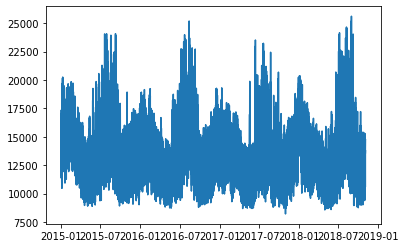

In [5]:
# Original series
plt.plot(date, y)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
Plot Histogram
Box-Cox transformation
Plot Histogram after Box-Cox Transformation


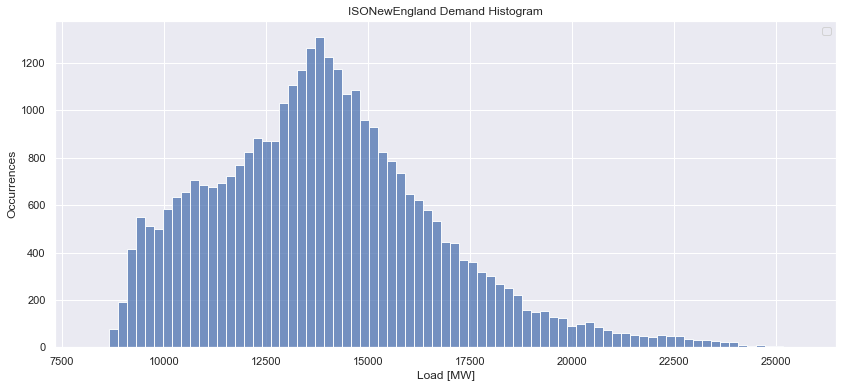

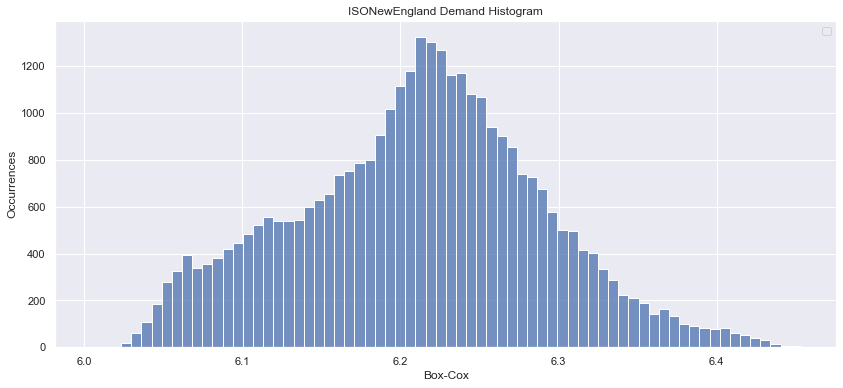

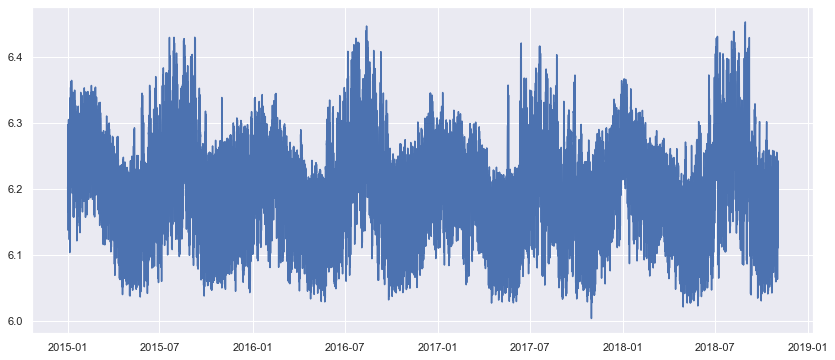

In [6]:
import seaborn as sns
from scipy import stats, special
sns.set(rc={'figure.figsize':(14, 6)})

# Set to True if want to use BoxCox
BOXCOX = True 

def plot_histogram(y_, xlabel):
    plt.figure()
    plt.title(f'{DATASET_NAME} Demand Histogram')
    plt.ylabel("Occurrences")
    if xlabel is not None:
        plt.xlabel(xlabel)
    sns.histplot(y_)
    plt.legend()
    
print("Plot Histogram")
plot_histogram(y, xlabel='Load [MW]')    

y_original = y
if BOXCOX:
    y_transf = y
    print("Box-Cox transformation")
    if len(y_transf.shape) > 1:
        y_transf = y_transf.reshape(y_transf.shape[0])
    y_transf, lambda_boxcox = stats.boxcox(y_transf)
    y = pd.DataFrame({'DEMAND':y_transf})
    print("Plot Histogram after Box-Cox Transformation")
    plot_histogram(y, xlabel='Box-Cox')
    plt.figure()
    plt.plot(date,y)

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, learning_curve, train_test_split

forecastDays = 15

testSize = forecastDays*24/X.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 0, shuffle = False)

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred_train = model.predict(X_train)
r2train = r2_score(y_train, y_pred_train)
r2test = r2_score(y_test, y_pred)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2train))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2test))
n = len(X_test)
p = X_test.shape[1]
adjr2_score= 1-((1-r2test)*(n-1)/(n-p-1))
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adjr2_score))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

mae = mean_absolute_error(y_test, y_pred)
print("MAE: %f" % (mae))

try:
    y_test = y_test.values.reshape(y_test.shape[0])
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mape(y_test, y_pred)
except AttributeError:
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mape(y_test, y_pred)
print("MAPE: %.2f%%" % (mape))
print("sMAPE: %.2f%%" % (smape))

The R2 score on the Train set is:	0.958
The R2 score on the Test set is:	0.734
The Adjusted R2 score on the Test set is:	0.730
RMSE: 0.029068
MAE: 0.023191
MAPE: 0.38%
sMAPE: 0.38%


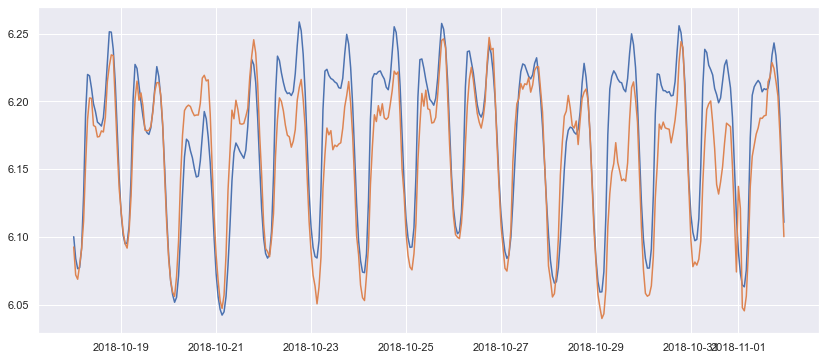

In [9]:
# Prepare for plotting
rows = X_test.index
date2 = date.iloc[rows[0]:]

plt.figure()
plt.plot(date2, y_test)
plt.plot(date2, y_pred)
plt.show()

Demand decomposed using ewt


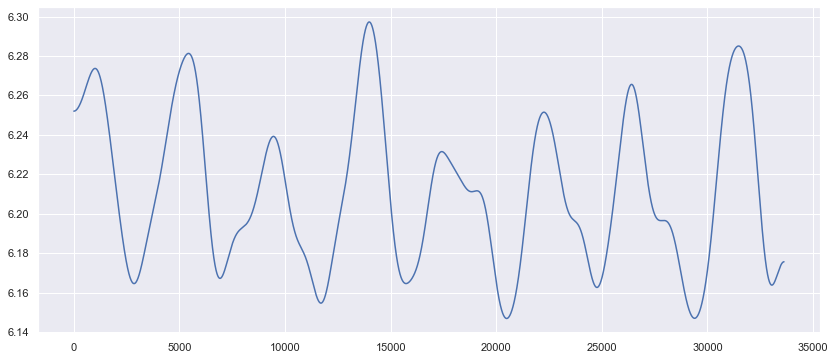

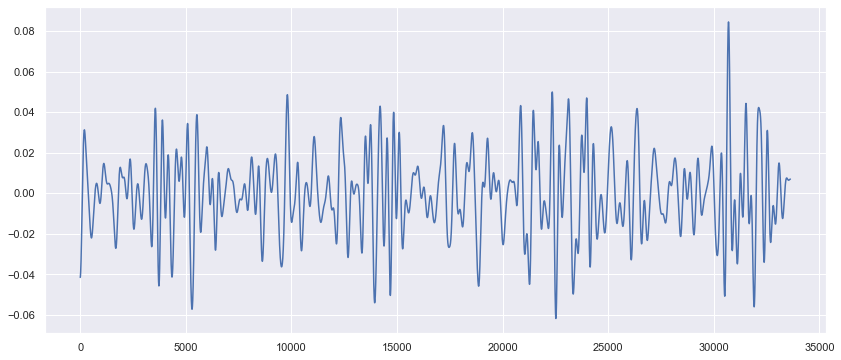

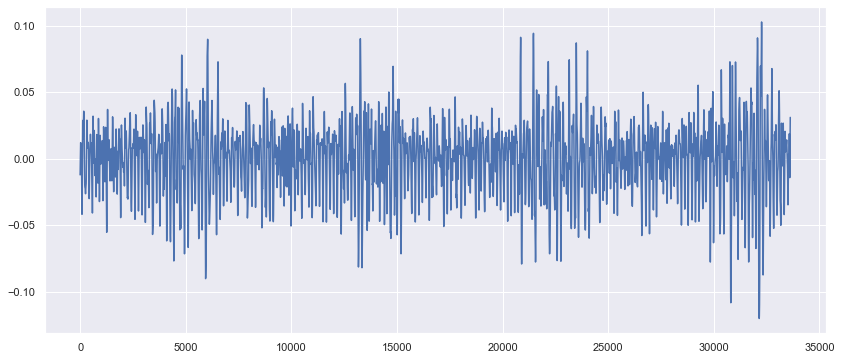

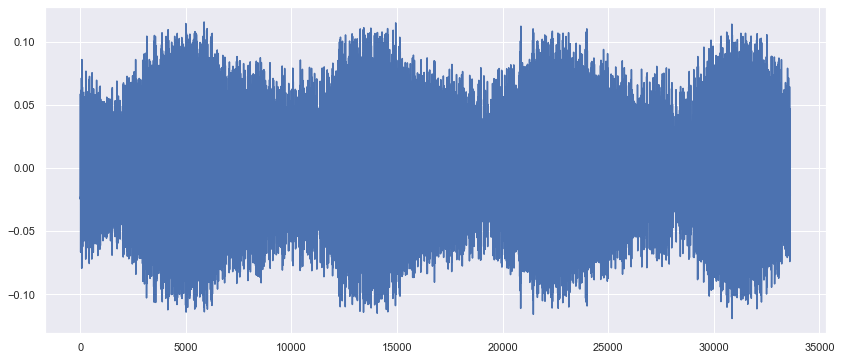

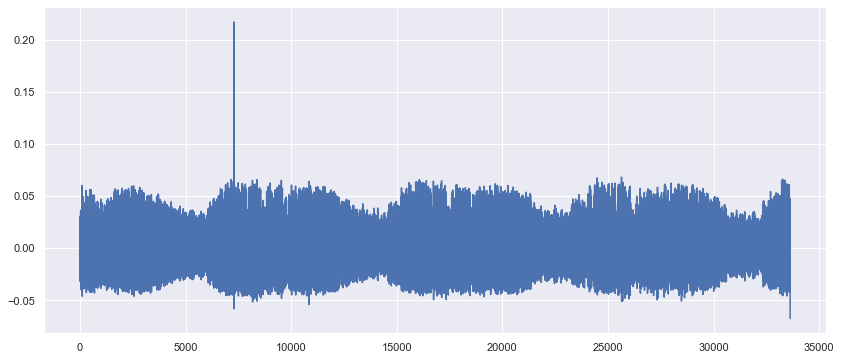

In [10]:
# Decomposing signals
print("Demand decomposed using ewt")
import ewtpy
def do_ewt(y_, Nmodes=3):
    y_series = np.array(y_)
    try:
        if y_series.shape[0] == 1:
            y_series = y_series.reshape(y_series.shape[1])
        elif y_series.shape[1] == 1:
            y_series = y_series.reshape(y_series.shape[0])
    except IndexError:
        pass

    # EWT - Empirical Wavelet Transform
    FFTreg = 'gaussian'
    FFTregLen = 25
    gaussSigma = 5        
    ewt,_,_ = ewtpy.EWT1D(y_series, N = Nmodes, log = 0,
                    detect = "locmax", 
                    completion = 0, 
                    reg = FFTreg, 
                    lengthFilter = FFTregLen,
                    sigmaFilter = gaussSigma)
    IMFs = []
    for i in range(ewt.shape[1]):
        IMFs.append(ewt[:,i])        

    

    series_IMFs = []
    for i in range(len(IMFs)):
        series_IMFs.append(pd.DataFrame({f"IMF_{i}":IMFs[i]}))
    return series_IMFs


y_decomposed_list = do_ewt(y, Nmodes=5)

for y_decomposed in y_decomposed_list:
    plt.figure()
    plt.plot(y_decomposed)

0.9960647746675854

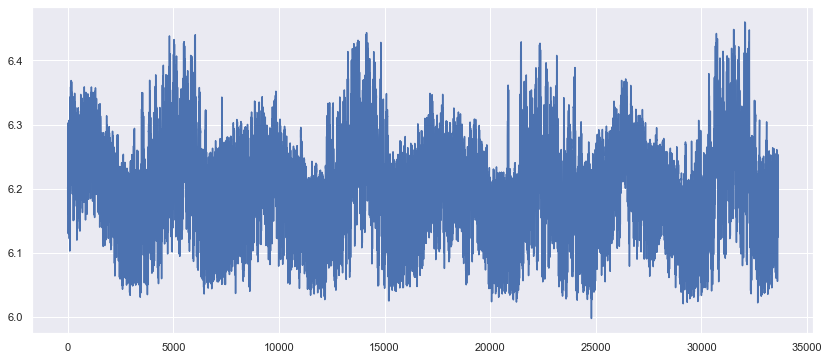

In [11]:
# Make sure decomposition is correct by composing the signals
y_composed = np.sum([*y_decomposed_list], axis=0) 
plt.plot(y_composed)
r2_score(y, y_composed)

The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	-24.109
The Adjusted R2 score on the Test set is:	-24.536
RMSE: 0.012196
MAE: 0.010483
MAPE: 0.17%
sMAPE: 0.17%
The R2 score on the Train set is:	0.922
The R2 score on the Test set is:	-3.339
The Adjusted R2 score on the Test set is:	-3.412
RMSE: 0.012991
MAE: 0.011281
MAPE: 203.85%
sMAPE: 162.09%
The R2 score on the Train set is:	0.799
The R2 score on the Test set is:	-0.674
The Adjusted R2 score on the Test set is:	-0.702
RMSE: 0.023287
MAE: 0.020051
MAPE: 741.32%
sMAPE: 149.01%
The R2 score on the Train set is:	0.981
The R2 score on the Test set is:	0.954
The Adjusted R2 score on the Test set is:	0.953
RMSE: 0.009227
MAE: 0.007133
MAPE: 70.00%
sMAPE: 31.45%
The R2 score on the Train set is:	0.941
The R2 score on the Test set is:	0.905
The Adjusted R2 score on the Test set is:	0.903
RMSE: 0.009564
MAE: 0.006938
MAPE: 155.34%
sMAPE: 39.93%


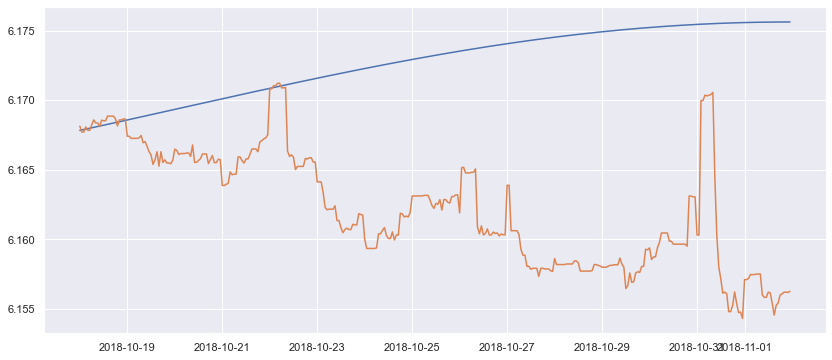

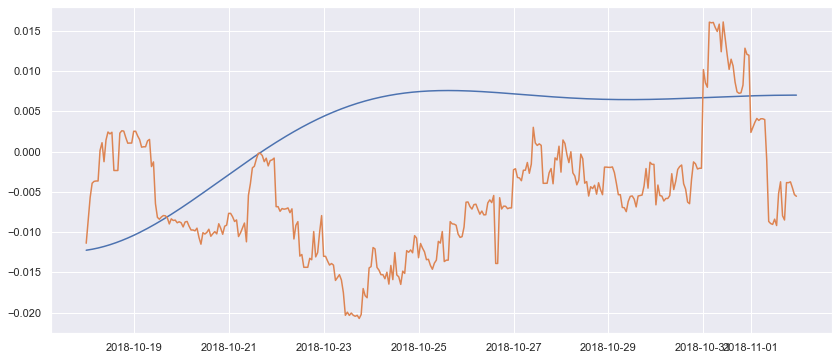

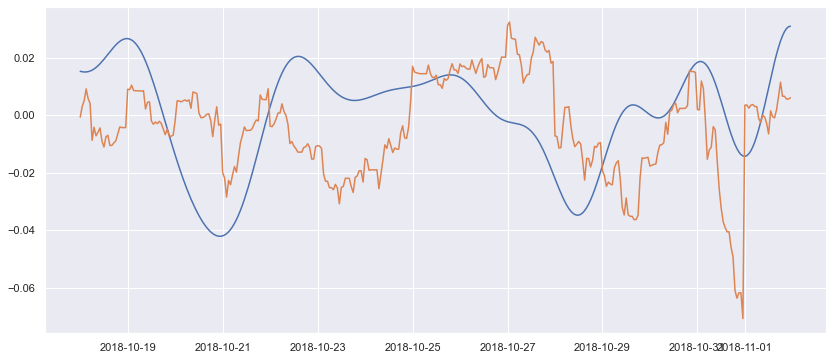

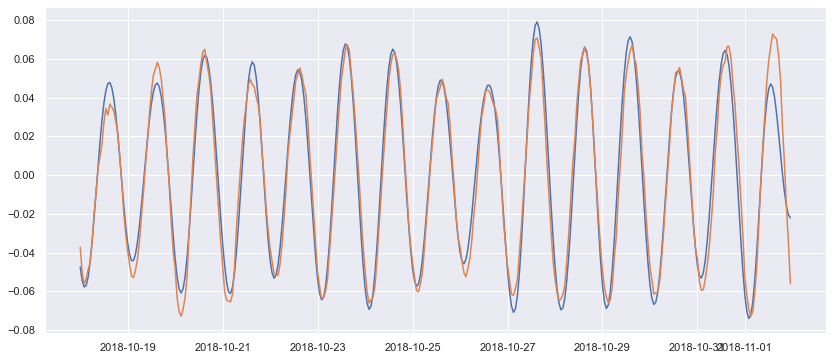

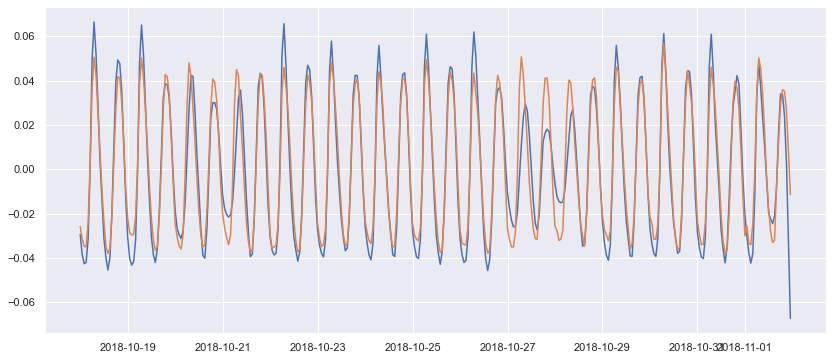

In [12]:
# Load forecast decomposed signals
# List to save predicted signals
decomposePred = []
for y_decomposed in y_decomposed_list:
    
    # setup for prediction
    forecastDays = 15

    testSize = forecastDays*24/X.shape[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y_decomposed, test_size = testSize, random_state = 0, shuffle = False)

    # Forecast
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plotting
    rows = X_test.index
    date2 = date.iloc[rows[0]:]
    plt.figure()
    plt.plot(date2, y_test)
    plt.plot(date2, y_pred)
    
    # Metrics
    y_pred_train = model.predict(X_train)
    r2train = r2_score(y_train, y_pred_train)
    r2test = r2_score(y_test, y_pred)
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2train))
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2test))
    n = len(X_test)
    p = X_test.shape[1]
    adjr2_score= 1-((1-r2test)*(n-1)/(n-p-1))
    print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adjr2_score))

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: %f" % (rmse))

    mae = mean_absolute_error(y_test, y_pred)
    print("MAE: %f" % (mae))

    try:
        y_test = y_test.values.reshape(y_test.shape[0])
        mape = mean_absolute_percentage_error(y_test, y_pred)
        smape = symmetric_mape(y_test, y_pred)
    except AttributeError:
        mape = mean_absolute_percentage_error(y_test, y_pred)
        smape = symmetric_mape(y_test, y_pred)
    print("MAPE: %.2f%%" % (mape))
    print("sMAPE: %.2f%%" % (smape))

    # Save predicted y
    decomposePred.append(y_pred)


The R2 score on the Test set is:	0.630
The Adjusted R2 score on the Test set is:	0.624
RMSE: 1023.862117
MAE: 828.895114
MAPE: 6.45%
sMAPE: 6.69%


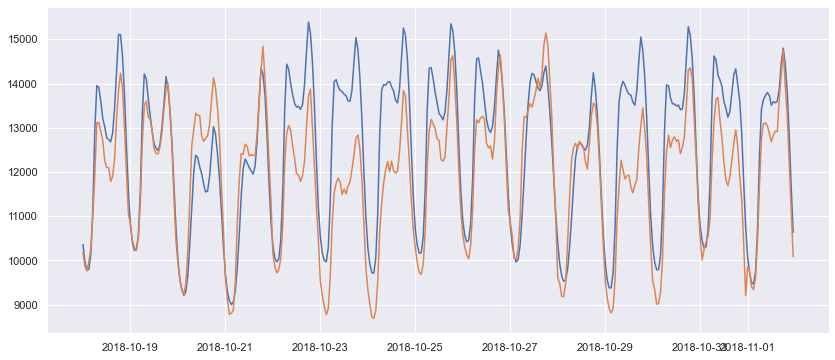

In [13]:

# Make sure decomposition is correct by composing the signals
y_composed = np.sum([*decomposePred], axis=0) 

if BOXCOX:
    y_composed = special.inv_boxcox(y_composed, lambda_boxcox)
    y = y_original

# setup for prediction
forecastDays = 15
testSize = forecastDays*24/X.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 0, shuffle = False)

# Metrics
r2test = r2_score(y_test, y_composed)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2test))
n = len(X_test)
p = X_test.shape[1]
adjr2_score= 1-((1-r2test)*(n-1)/(n-p-1))
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adjr2_score))

rmse = np.sqrt(mean_squared_error(y_test, y_composed))
print("RMSE: %f" % (rmse))

mae = mean_absolute_error(y_test, y_composed)
print("MAE: %f" % (mae))

try:
    y_test = y_test.values.reshape(y_test.shape[0])
    mape = mean_absolute_percentage_error(y_test, y_composed)
    smape = symmetric_mape(y_test, y_composed)
except AttributeError:
    mape = mean_absolute_percentage_error(y_test, y_composed)
    smape = symmetric_mape(y_test, y_composed)
print("MAPE: %.2f%%" % (mape))
print("sMAPE: %.2f%%" % (smape))

plt.figure()
plt.plot(date2, y_test)
plt.plot(date2, y_composed)
plt.show()